In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

%matplotlib inline

In [4]:
# Load the data
DIR = 'D:\PlayGround\kaggle\WebTraffic'
train = pd.read_csv(os.path.join(DIR, "train_1.csv"))
keys = pd.read_csv(os.path.join(DIR, "key_1.csv"))
# ss = pd.read_csv(os.path.join(DIR, "sample_submission_1.csv"))

In [5]:
del keys

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## 2. Data transformation and helper functions
### A. Article names and metadata

In [7]:
import re

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""

print(breakdown_topic("Рудова,_Наталья_Александровна_ru.wikipedia.org_all-access_spider"))
print(breakdown_topic("台灣災難列表_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("File:Memphis_Blues_Tour_2010.jpg_commons.wikimedia.org_mobile-web_all-agents"))

('Рудова,_Наталья_Александровна', 'ru', 'all-access', 'spider')
('台灣災難列表', 'zh', 'all-access', 'spider')
('', '', '', '')


In [8]:
page_details = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

page_details[0:10]

C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


###  B. Split into train and validation dataset

In [9]:
# Generate train and validate dataset
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:10])
print("The validation set sample:")
print(y_train[0:10])

The training set sample:
              topic lang      access    type  \
0              2NE1   zh  all-access  spider   
1               2PM   zh  all-access  spider   
2                3C   zh  all-access  spider   
3           4minute   zh  all-access  spider   
4  52_Hz_I_Love_You   zh  all-access  spider   
5              5566   zh  all-access  spider   
6            91Days   zh  all-access  spider   
7             A'N'D   zh  all-access  spider   
8             AKB48   zh  all-access  spider   
9             ASCII   zh  all-access  spider   

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-acces

## 3 Forecast methods

### A. SMAPE, the measurement


In [10]:
def smape(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    #print(np.sum(evals), len(data), np.sum(evals) * 1.0 / len(data))
    
    result = np.sum(evals) / len(data)
    
    return result

# create testing series
testing_series_1 = X_train.iloc[0, 5:494]
testing_series_2 = X_train.iloc[0, 5:494].shift(-1)
testing_series_3 = X_train.iloc[1, 5:494]
testing_series_4 = pd.Series([0,0,0,0])

In [17]:
# 提取序列
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

# 实际值和预测值绘图函数
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

### B. Simple median model

### C. Median model - weekday, weekend and holiday

### D. ARIMA model

In [11]:
from statsmodels.tsa.arima_model import ARIMA   
import warnings

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)

    #print(result.params)
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx,typ='levels')

    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')

    return smape(forecast_series, actual_series)

C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

      ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2     ...             3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


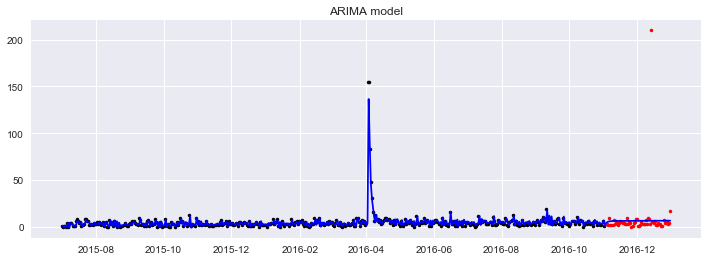

The SMAPE score is : 0.65757


In [16]:
# This is to demo the ARIMA model
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

In [25]:
df_train1 = extract_series(X_train, 2222, 5).copy()
df_actual1 = extract_series(y_train, 2222, 5).copy()

df_train1 = df_train1.fillna(0)

In [26]:
train_series = df_train1.y
train_series.index = df_train1.ds
arima = ARIMA(train_series ,[2, 1, 2])
result = arima.fit(disp=False)

C:\Users\shenchen3\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
actual_series = df_actual1.y
actual_series.index = pd.to_datetime(df_actual1.ds)

In [29]:
start_idx = df_train.ds[1]
end_idx = df_actual.ds.max()

In [32]:
forecast_series = result.predict(start_idx, end_idx,typ='levels')